[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Total sentiment in train set:
Sentiment
positive    12084
neutral      1270
negative      989
Name: count, dtype: int64

Total sentiment in test set:
Sentiment
positive    5193
neutral      523
negative     432
Name: count, dtype: int64
Epoch 1/10, Loss: 0.7015695631907158, Accuracy: 0.842501568709475
Epoch 2/10, Loss: 0.5728089696425304, Accuracy: 0.842501568709475
Epoch 3/10, Loss: 0.5448581491654981, Accuracy: 0.842501568709475
Epoch 4/10, Loss: 0.5299993021849898, Accuracy: 0.842501568709475
Epoch 5/10, Loss: 0.5153878458264498, Accuracy: 0.842501568709475
Epoch 6/10, Loss: 0.5035551011423133, Accuracy: 0.842501568709475
Epoch 7/10, Loss: 0.48647238975005747, Accuracy: 0.842501568709475
Epoch 8/10, Loss: 0.4653236503810686, Accuracy: 0.842501568709475
Epoch 9/10, Loss: 0.4462626750462725, Accuracy: 0.842501568709475
Epoch 10/10, Loss: 0.42569103517235135, Accuracy: 0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


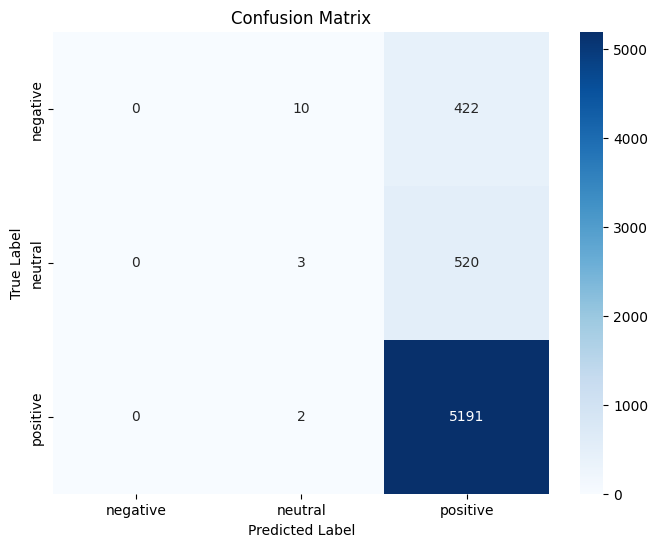

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import KeyedVectors
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


# Load dataset
data_path = '/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

# Create sentiment labels from ratings
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(rating_to_sentiment)

# Convert 'Sentiment' column to category
data['Sentiment'] = data['Sentiment'].astype('category')

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Print total sentiment in train and test set
print("\nTotal sentiment in train set:")
print(train_labels.value_counts())

print("\nTotal sentiment in test set:")
print(test_labels.value_counts())

# Load FastText model
fasttext_model_path = '/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec'
fasttext_vectors = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# Convert text data to FastText vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [fasttext_vectors[word] for word in tokens if word in fasttext_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

train_vectors = np.array([text_to_vector(text) for text in train_texts])
test_vectors = np.array([text_to_vector(text) for text in test_texts])

# Normalize vectors
train_vectors = normalize(train_vectors, axis=1)
test_vectors = normalize(test_vectors, axis=1)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
train_vectors_smote, train_labels_smote = smote.fit_resample(train_vectors, train_labels)

train_vectors, train_labels = train_vectors_smote, train_labels_smote

# Convert the numpy arrays back to pandas Series and ensure they are of type category
train_labels = pd.Series(train_labels, dtype="category")
test_labels = pd.Series(test_labels, dtype="category")

# Check the distribution of the new training labels
print("Combined training label distribution:")
print(Counter(train_labels))

# Calculate class weights
class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Convert class weights to tensor
class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32)

# LSTM Model with dropout
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add dimension for seq_length
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# Define parameters
input_size = 300  # Size of FastText word vectors
hidden_size = 512
output_size = len(data['Sentiment'].unique())

# Create LSTM model instance
lstm_model = SentimentLSTM(input_size, hidden_size, output_size, num_layers=2, dropout=0.3)

# Move class weights to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class_weights_tensor = class_weights_tensor.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Convert data to tensors
train_vectors_tensor = torch.tensor(train_vectors, dtype=torch.float32).to(device)
test_vectors_tensor = torch.tensor(test_vectors, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels.cat.codes.values, dtype=torch.long).to(device)
test_labels_tensor = torch.tensor(test_labels.cat.codes.values, dtype=torch.long).to(device)

# Define DataLoader
train_dataset = torch.utils.data.TensorDataset(train_vectors_tensor, train_labels_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
def train_model(model, train_loader, optimizer, loss_fn, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return model

# Move model to GPU if available
lstm_model = lstm_model.to(device)

# Train the LSTM model
trained_lstm_model = train_model(lstm_model, train_loader, optimizer, loss_fn, num_epochs=30)

# Evaluate the model
def evaluate_model(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        _, predicted = torch.max(outputs, 1)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return cm, cr

# Convert test data to tensor
test_vectors_tensor = test_vectors_tensor.to(device)
test_labels_tensor = test_labels_tensor.to(device)

# Evaluate the LSTM model
conf_matrix, class_report = evaluate_model(trained_lstm_model, test_vectors_tensor, test_labels_tensor)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, ['negative', 'neutral', 'positive'])
